# <img src="https://raw.githubusercontent.com/HevlerJohannes/Bertozzi_MS_QC/main/picture.png" height="200" align="right" style="height:240px">

## **The offical mass spectrometry QC tool of the [Bertozzi group](https://bertozzigroup.stanford.edu/)**


###### **Author:** Johannes F. Hevler (<jfhevler@stanford.edu>)
###### **Github:** [Bertozzi_MS_OC](https://github.com/HevlerJohannes/Bertozzi_MS_QC)
-------
Easy to use QC analysis tool for the analysis of mass-spectrometry compatible (human) protein extracts ([Details](https://www.promega.com/products/mass-spectrometry/mass-spec-reference-reagents/mass-spec-compatible-yeast-and-human-protein-extracts/?catNum=V6951.)).

This tool is based on the **MetaMorpheus** ([command line tool](https://github.com/smith-chem-wisc/MetaMorpheus/wiki/Getting-Started#test-installation-via-net-core-dll---linux-macos-windows)), developed by the [Lloyd M. Smith lab](https://pubs.acs.org/doi/10.1021/acs.jproteome.7b00873).

**Usage**
- For first time users: Go to the tools github page and follow instructions in the [README](https://github.com/HevlerJohannes/Bertozzi_MS_QC/blob/main/README.md).

 - To run the notebook cell by cell, press the little ▶ _Play_ button.

 - Alternatively, go to Runtime -> Run all (or Crtl + F9). After uploading the raw file you can then "walk away" and you will be notified by email once your search was completed.


**Limitations**
- This notebook is **primarly** designed for the QC data analysis to access the performance of a **Thermo Fischer Mass spectrometer (.raw files)**.

- By default, this notebook does **NOT** support the usage of **Bruker .d spectral files**.

- In order to use this colab you need to have a **google account** with access to [Google Drive](https://www.google.com/drive/) and [Gmail](https://mail.google.com/mail/u/0/).   

In [1]:
#@title **1. Set up GoogleColab environment and install dependencies**
#@markdown
#@markdown Please execute this cell by pressing the little ▶ _Play_ button
#@markdown on the left to download and import neccessary dependencies!<br/>
#@markdown Please be aware that this **`can take a bit of time`**.

# Check whether google drive is mounted and if not mount to drive
from google.colab import drive
import os

# Check if the directory '/content/drive' exists
if not os.path.exists('/content/drive'):
    # If it doesn't exist, mount Google Drive
    drive.mount('/content/drive')
else:
    print("Already mounted to Google Drive.")

# Install dependencies needed to run this tool in Linux environment (GoogleColab).
from IPython.display import Markdown, display

def print_bold(string):
    display(Markdown(f"**{string}**"))

print_bold('Environment is getting set up for you...')

try:

  ## Updating package repositories...
  print("Updating package repositories...")
  !apt-get update -qq >/dev/null 2>&1

  ## Install dependencies to visualize chromatograms
  print("Installing dependencies...")
  !pip install -q fisher_py >/dev/null 2>&1
  !apt-get -qq install mono-complete >/dev/null 2>&1

  ## Install  .NET SDK and make it executable
  print("Still installing...")
  !wget https://dotnet.microsoft.com/download/dotnet/scripts/v1/dotnet-install.sh >/dev/null 2>&1
  !chmod +x dotnet-install.sh >/dev/null 2>&1
  !./dotnet-install.sh --install-dir /usr/share/dotnet --version 6.0.100 --verbose >/dev/null 2>&1

except Exception:
  # Code to handle the exception
  print("An exception occurred - Installation of dependencies was not succesful")

else:

  # Print a message indicating successful set up
  print_bold("Set-up and installation of dependencies was successful.")

  # Import dependencies
  import warnings
  warnings.filterwarnings("ignore")
  from google.colab import files
  import os
  import re
  import subprocess
  import numpy as np
  from scipy.interpolate import interp1d
  import matplotlib.pyplot as plt
  from fisher_py import RawFile
  from fisher_py.data.business import TraceType
  import random
  import pandas as pd
  import csv
  import shutil
  import smtplib
  import sys
  import mimetypes
  from email.mime.image import MIMEImage
  from email.mime.multipart import MIMEMultipart
  from email.mime.text import MIMEText
  from email.mime.base import MIMEBase
  from email import encoders
  from google.colab import files

Mounted at /content/drive


**Environment is getting set up for you...**

Updating package repositories...
Installing dependencies...
Still installing...


**Set-up and installation of dependencies was successful.**

In [2]:
#@title **2. Set up tool directory and upload a single .raw file for QC analysis**
#@markdown
#@markdown Please execute this cell by pressing the little ▶ _Play_ button
#@markdown on the left to upload respective .raw file!
#@markdown - Disclaimer: Uploading .raw files is slow, so you can also manually upload a file. In that case please
#@markdown upload the .raw file to the raw folder in the **tool_dir/temp_data directory** and select **raw_file_uploaded: Yes**!<br>
#@markdown - Make sure that only a single file is in the folder!
#@markdown - For optimal performance use this naming convention:
#@markdown  - "date_instrument_add_info_user-initials.raw" (e.g. 20231107_Fusion_QC_K562_after_calibration_JFH.raw)

# Prompt the user to define the path to the QC tool
tool_dir = '/content/drive/MyDrive/Bertozzi_QC' #@param {type:"string"}

# Ask user whether raw file is uploaded
raw_file_uploaded = 'Yes' #@param ["Yes", "No"]


os.chdir(tool_dir+'/temp_data/')

# Name of the folder you want to check/create
folder_name = 'raw'

# Path to the folder
folder_path = os.path.join(tool_dir+'/temp_data/', folder_name)
# Check if the folder exists
if not os.path.exists(folder_path):
    # Create the folder if it does not exist
    os.makedirs(folder_path)

if raw_file_uploaded == 'No':

  # Prompt the user to upload a file
  print_bold("Choose a single .raw file to upload:")
  uploaded = files.upload()

  # Check if any files were uploaded
  if len(uploaded) == 0:
      print_bold('No file uploaded. Please try again.')
  else:
      # Get the first uploaded filename
      filename = next(iter(uploaded))

      # Check if the filename has the correct extension
      if not filename.endswith('.raw'):
          print_bold('Error: The uploaded file must have the .raw extension. Please upload a file with the correct extension.')

          # Delete the uploaded file to stop the upload process
          os.remove(filename)
          print_bold("File deleted.")

      else:
          # Continue with the upload process
          print_bold('Great, ' + filename + ' has been successfully uploaded - you are all set to start your QC search!')

else:
  # Get a list of all files in the folder
  files = os.listdir(folder_path)
  # Check if any files were found
  if len(files) == 0:
    raise ValueError(print_bold('No files found in the .raw folder. Please check if the folder contains any files!'))

  else:
    # Print the file names
    for file_name in files:
      raw_filename = file_name
      print_bold('Great, I can see that ' + file_name + ' has been successfully uploaded by you. You are all set to start your QC search!')


**Great, I can see that 20250628_Fusion_QC_K562_200ng_plate_after_MLS.raw has been successfully uploaded by you. You are all set to start your QC search!**

In [3]:
#@title **3. Perform QC analysis**
#@markdown
#@markdown Please execute this cell by pressing the little ▶ _Play_ button.<br/>
#@markdown In order to run this a **single .raw** file needs to be uploaded (see **produced message section 2**).<br/>
#@markdown - Disclaimer: This **`can take a bit of time (~10 min)`**.

# Run metamorpheus analysis
os.environ['PATH'] += ":/usr/share/dotnet"
os.chdir(tool_dir+'/metamorpheus')

# Print a message indicating the start of the search
print_bold("Running metamorpheus search...")
metamorpheus_run = subprocess.run(['dotnet', 'CMD.dll', '-t', tool_dir+'/bin/metamorpheus_search/Standard_qc_search.toml', '-s', folder_path+'/'+file_name, '-d', tool_dir+'/bin/metamorpheus_search/Human_UP000005640_9606.fasta', '-o', tool_dir+'/temp_data'], capture_output=True, text=True)

# Print a message indicating the end of the search
print_bold("...Finished metamorpheus search. Preparing summery and visualization of QC data!")

# Preparing summery and visualization of data
## Get the path where metamorpheus results are stored
start_pattern = r"writing file: "
end_pattern = r"/Task"

# Construct the regular expression pattern
pattern = rf"{re.escape(start_pattern)}(.*?){re.escape(end_pattern)}"

# Use re.search to find the first occurrence of the pattern
match = re.search(pattern, metamorpheus_run.stdout)

# Extract the matched string
if match:
    extracted_string = match.group(1)
else:
    raise ValueError("Path with metamorpheus search results cannot be found.")


**Running metamorpheus search...**

**...Finished metamorpheus search. Preparing summery and visualization of QC data!**

**The newest QC data was added to /content/drive/MyDrive/Bertozzi_QC/performance_log/qc_performance_log.csv**

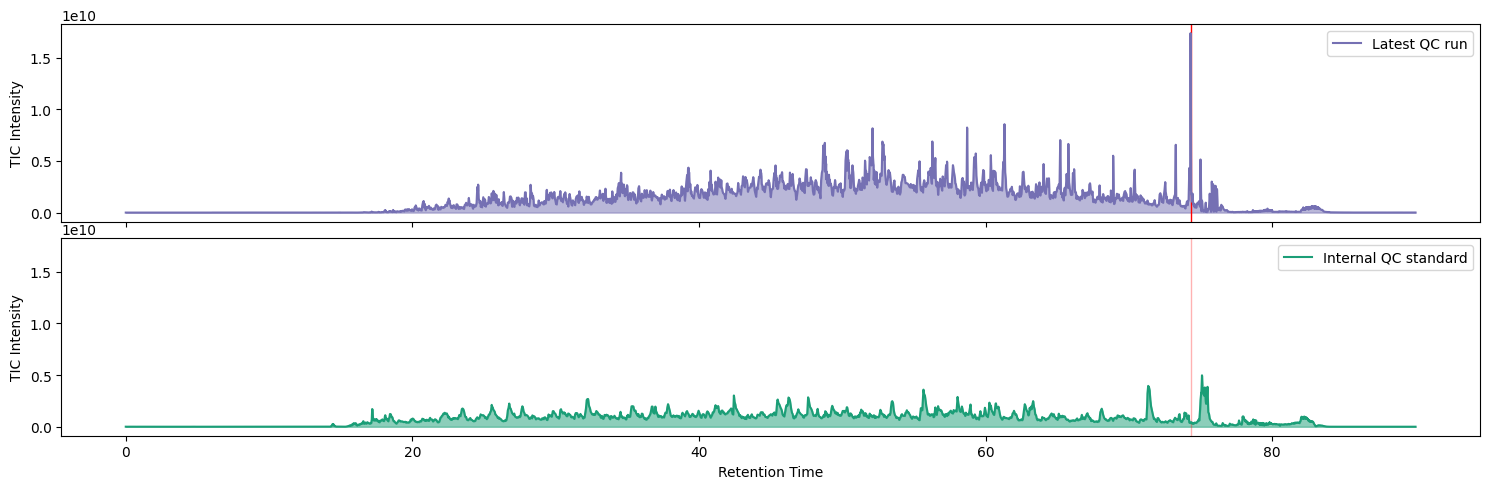

In [4]:
#@title **4. Generate QC report and visualize results from search**
#@markdown
#@markdown ### Please execute this cell by pressing the little ▶ _Play_ button.<br/>

#@markdown ---
#@markdown ### Tick field, if your .raw file has this naming convention:
#@markdown - "date_instrument_add_info_user-initials.raw"
#@markdown  - (e.g. 20231107_Fusion_QC_K562_after_calibration_JFH.raw)
correct_raw_file_naming = True #@param {type:"boolean"}

if correct_raw_file_naming == True:
  Date = re.search(r'\d{8}', raw_filename).group()
  MS_instrument = re.search(r'.*\d{8}_(.*?)_.*', raw_filename).group(1)
  Add_info = '_'.join(raw_filename.split('_')[2:-1])
  QC_operator = re.search(r'.*_(.*?).raw.*', raw_filename).group(1)

else:
#@markdown ---
#@markdown ### Add information manually if naming differs:
#@markdown - only fill if file naming convention **differs** from aboves style.
#@markdown - set **correct_raw_file_naming** to **False (untick)**
  Date = '2024-07-02' #@param {type:"date"}
  MS_instrument = '' #@param {type:"string"}
  Add_info = '' #@param {type:"string"}
  User_initials = '' #@param {type:"string"}

# Define the pattern to extract the string between
start_pattern = r"writing file: "
end_pattern = r"/Task"

# Construct the regular expression pattern
pattern = rf"{re.escape(start_pattern)}(.*?){re.escape(end_pattern)}"

# Use re.search to find the first occurrence of the pattern
match = re.search(pattern, metamorpheus_run.stdout)

# Extract the matched string
if match:
    extracted_string = match.group(1)
else:
    raise ValueError("Path with metamorpheus search results cannot be found.")

# Open summary file with search results:
f = open(extracted_string + '/Task1SearchTask/results.txt', 'r')
lines=f.readlines()
result_sum = lines[4:22]

result_sum_str = '\n'.join(result_sum)
result_sum_str_cleaned = re.sub(r'\n{2,}', '\n', result_sum_str)

# Calculate m/z error
psms_df = pd.read_csv(extracted_string + '/Task1SearchTask/AllPSMs.psmtsv', sep='\t')
psms_df['Mass Diff (ppm)'] = pd.to_numeric(psms_df['Mass Diff (ppm)'], errors='coerce')
target_psms_df = psms_df[(psms_df['QValue'] < 0.01) & (psms_df['QValue Notch'] < 0.01)]
target_psms_df['Mass Diff (ppm)'] = pd.to_numeric(target_psms_df['Mass Diff (ppm)'], errors='coerce')
target_psms_df = target_psms_df.dropna(subset=['Mass Diff (ppm)'])
ppm_error_q001 = np.nanmedian(target_psms_df['Mass Diff (ppm)'].values)
ppm_error_notch0 = np.nanmedian(psms_df[psms_df['Notch'] == 0]['Mass Diff (ppm)'].values)
# Add mass error to report
# Define the pattern
pattern_to_match = 'All target protein groups with q-value = 0.01 \(1% FDR\): (\d+)'
# String to insert
insert_error = '\nMedian ppm error with q-value = 0.01 = ' + f'{ppm_error_q001}\nMedian ppm error with Notch = 0: ' + f'{ppm_error_notch0}'

# Insert string to result summary
result_sum_final = re.sub(pattern_to_match, f"\\g<0>{insert_error}", result_sum_str_cleaned)


# Extract numbers to generate the report and track instrument performance
import pandas as pd
qc_data_df = pd.DataFrame({'rawfile': raw_filename, 'date': Date, 'instrument': MS_instrument,
              'operator': QC_operator, 'info': Add_info,
              'psms': int(re.search(r'All target PSMs with q-value = 0.01: (\d+)', result_sum_str_cleaned).group(1)),
              'peptides': int(re.search(r'All target peptides with q-value = 0.01 : (\d+)', result_sum_str_cleaned).group(1)),
              'proteins': int(re.search(r'All target protein groups with q-value = 0.01 \(1% FDR\): (\d+)', result_sum_str_cleaned).group(1)),
              'Median_ppm_error_target_psms': ppm_error_q001,
              'Median_ppm_error_notch_0': ppm_error_notch0,
              'number_ms2_spectra': int(re.search(r'MS2 spectra in ' + f'{file_name.split(".raw")[0]}' + ': (\d+)', result_sum_str_cleaned).group(1))}, index=[0])

# Append data to performance log file
## Path to the CSV file
file_path_logfile = tool_dir+'/performance_log/qc_performance_log.csv'

# Check whether a file already exists
if os.path.exists(file_path_logfile):
  # Create a backup file
  backup_file_path = file_path_logfile + '.bak'
  shutil.copyfile(file_path_logfile, backup_file_path)
  # Append data
  qc_data_df.to_csv(file_path_logfile, mode='a', index=False, header=False)
  print_bold('The newest QC data was added to '+ file_path_logfile)

# If no performance log file exist, generate a new one
else:
  qc_data_df.to_csv(file_path_logfile, mode='w', index=False, header=True)
  print_bold('A new QC log file was generated: file_path_logfile')

# Visualizing
os.environ["PYTHONNET_PYDLL"] = "/path/to/libcoreclr.so"

# Load raw files
current_raw_file = RawFile(folder_path+'/'+file_name)
qc_standard_raw_file = RawFile(tool_dir+'/bin/qc_standard_raw/20231107_Fusion_QC_K562_after_calibration_JFH.raw')
target_mass = 0
mass_tolerance_ppm = 0
rt1, i1 = current_raw_file.get_chromatogram(target_mass, mass_tolerance_ppm, TraceType.TIC, ms_filter='ms')
rt2, i2 = qc_standard_raw_file.get_chromatogram(target_mass, mass_tolerance_ppm, TraceType.TIC, ms_filter='ms')

# Interpolate y2 to match the x values of y1
f = interp1d(rt2, i2, kind='linear')

# Clip the x-values of rt1 to ensure they fall within the range of rt2
rt1_clipped = np.clip(rt1, rt2[0], rt2[-1])
y2_interp = f(rt1_clipped)

# Calculate the absolute difference between the two curves
diff = np.abs(i1 - y2_interp)
# Normalize the array to the range [0, 1]
normalized_diff = (diff - np.min(diff)) / (np.max(diff) - np.min(diff))


# Set a threshold for highlighting sections with the biggest differences
threshold = 0.5

# Create a boolean mask for highlighting
highlight = normalized_diff > threshold

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 5), sharex=True, sharey=True)

# Plot the first curve and highlight differences
ax1.plot(rt1, i1, label='Latest QC run', alpha=1, color='#7570b3')
ax1.fill_between(rt1, i1, 0, alpha=0.5, color='#7570b3')
for i in range(len(rt1) - 1):
    if highlight[i]:
        ax1.axvspan(rt1[i], rt1[i + 1], color='red', alpha=1)

# Plot the second curve and highlight differences
ax2.plot(rt1, y2_interp, label='Internal QC standard', alpha=1, color = '#1b9e77')
ax2.fill_between(rt1, y2_interp, 0, alpha=0.5, color = '#1b9e77')
for i in range(len(rt1) - 1):
    if highlight[i]:
        ax2.axvspan(rt1[i], rt1[i + 1], color='red', alpha=0.3)

# Set labels and legends
#ax1.set_xlabel('Retention Time')
ax1.set_ylabel('TIC Intensity')
ax1.legend()

ax2.set_xlabel('Retention Time')
ax2.set_ylabel('TIC Intensity')
ax2.legend()
plt.tight_layout()
plt.subplots_adjust(hspace=0.085)

# Save plot
plt.savefig(tool_dir+'/temp_data/MS1_TIC_plot.png')

# Show plot
plt.show()


In [ ]:
#@title **5. Summerize results and send email with results**
#@markdown
#@markdown Please execute this cell by pressing the little ▶ _Play_ button.<br/>
#@markdown - Disclaimer: In order to run this you need to have a .txt file with your gmail login credentials in  **tool_dir/bin/email**.

# Get a random motivational quote
def get_random_line(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        random_line = random.choice(lines)
    return random_line.strip()  # Strip to remove leading/trailing whitespaces

file_path = tool_dir+'/bin/etc/motivational_quotes_formatted.txt'
motivational_phrase = get_random_line(file_path)

# Prepare email
## Set Global Variables
folder_path_credentials = tool_dir + '/bin/email/'
file_name_credentials = "login_credentials.txt"
file_path_credentials = os.path.join(folder_path_credentials, file_name_credentials)

if os.path.exists(file_path_credentials):
    print_bold("A credential file was found. Sending email...")
else:
    print_bold(f"No Gmail credential file exists. Please generate a .txt file named '{file_name_credentials}' in '{folder_path_credentials}'.")
    sys.exit()

# Read lines, ignore comments and empty lines
with open(file_path_credentials, 'r') as login_cred:
    login_cred_lines = [
        line.strip()
        for line in login_cred
        if line.strip() and not line.strip().startswith("#")
    ]

# Expecting user and password to be the first two non-comment lines
if len(login_cred_lines) < 2:
    print_bold("Credential file is incomplete. It should contain at least two non-comment lines (email and password).")
    sys.exit()

gmail_user = login_cred_lines[0]
gmail_password = login_cred_lines[1]

## Prompt the user to define email addresses
mail_to = 'jfhevler@stanford.edu, dsroberts@stanford.edu, bmfloyd@stanford.edu, areiter@stanford.edu, mlschoof@stanford.edu' #@param {type:"string"}
mail_to = mail_to.split(", ")

## Prepare the email content
msg = MIMEMultipart()
msg['From'] = gmail_user
msg['To'] = ', '.join(mail_to)
msg['Subject'] = 'Bertozzi-MS-Bot: QC results for ' + file_name

greetings = "Hi my fellow ionizers, \n\nPlease find below a summary of your QC results:\n"
signature = "Have a lovely day,\nYour QC-Bot"
email_body = greetings + result_sum_final + signature + '\n--------------------------------------------------\n' + motivational_phrase

msg.attach(MIMEText(email_body, 'plain'))

## Add the image as an attachment
image_path = tool_dir+'/temp_data/MS1_TIC_plot.png'  # Adjust this to the path of your image
with open(image_path, 'rb') as f:
  img_data = f.read()
  image_type, _ = mimetypes.guess_type(image_path)
  image_subtype = image_type.split('/')[-1]
  image = MIMEImage(img_data, _subtype=image_subtype)
  image.add_header('Content-Disposition', 'attachment', filename=file_name+'ms1_tic.png')
  msg.attach(image)

## Sent Email
server = smtplib.SMTP_SSL('smtp.gmail.com', 465)
server.login(gmail_user, gmail_password)
server.sendmail(gmail_user, mail_to, msg.as_string())
server.close()



**A credential file was found. Sending email...**

In [6]:
#@title **6. Delete content of temp_data folder**
#@markdown
#@markdown Please execute this cell by pressing the little ▶ _Play_ button.<br/>
#@markdown - Disclaimer: Executing this cell will delete produced results in the temp_data folder.
directory = tool_dir+'/temp_data/'

# Get a list of all files in the directory
for item in os.listdir(directory):
    item_path = os.path.join(directory, item)
    if os.path.isdir(item_path):
        if item == 'raw':
            # Delete all files inside the 'raw' directory
            for filename in os.listdir(item_path):
                file_path = os.path.join(item_path, filename)
                try:
                    if os.path.isfile(file_path) or os.path.islink(file_path):
                        os.unlink(file_path)
                    elif os.path.isdir(file_path):
                        shutil.rmtree(file_path)
                except Exception as e:
                    print(f"Failed to delete {file_path}. Reason: {e}")
        else:
            # Delete the entire directory and its contents
            shutil.rmtree(item_path)
    elif os.path.isfile(item_path):
        os.remove(item_path)
